In [9]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import pickle
import matplotlib.pyplot as plt
#import cv2
#import plotly.graph_objs as go
import seaborn as sns
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
#import mplcursors 
import random
import torch
from scipy.stats import pearsonr

In [10]:
datasets_folder='/media/Blue2TB1'
datasets=['Jin_22','PAMI18','CVPR18','Fan_NOSSDAV_17']
dataset_colors = cm.rainbow(np.linspace(0, 1, len(datasets)))

In [11]:
def plot_SITI(dataset_name,datasets_folder, annotate_all=False, color='blue'):
    dataset_folder=os.path.join(datasets_folder,dataset_name)
    video_img_folder=os.path.join(dataset_folder, 'video_data')
    videos=os.listdir(video_img_folder)
    video_SIs=[]
    video_TIs=[]
    for video in videos:
        array_folder=os.path.join(video_img_folder,video)
        SI = np.load(os.path.join(array_folder, f'{video}_SI.npy'))
        TI = np.load(os.path.join(array_folder, f'{video}_TI.npy'))
        if np.mean(SI)>200:
            print(video)
            print(SI)
            print(np.mean(SI))
            return 0
        # Aggregating based on ITU-T P.910 (10/2023)
        video_SIs.append(np.mean(SI))
        video_TIs.append(np.mean(TI))
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.scatter(video_SIs, video_TIs, color=color, marker='o')

    if annotate_all:
        for i, video in enumerate(videos):
            plt.annotate(video, (video_SIs[i], video_TIs[i]))

    plt.title(f'Spatial and Temporal Information for {dataset_name}')
    plt.xlabel('Spatial Information (SI)')
    plt.ylabel('Temporal Information (TI)')
    plt.grid(True)
    
    plots_folder = os.path.join('Plots', 'SITI')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset_name}_SITI_plot.png')
    plt.savefig(plot_path)
    plt.show()
    

In [12]:
def plot_all_SITI(datasets_folder, datasets, annotate_all=False):
    plt.figure(figsize=(10, 6))
    colors = cm.rainbow(np.linspace(0, 1, len(datasets)))
    global_min_SI, global_max_SI = float('inf'), float('-inf')
    global_min_TI, global_max_TI = float('inf'), float('-inf')
    video_SIs={}
    video_TIs={}
    for idx, dataset_name in enumerate(datasets):
        dataset_folder = os.path.join(datasets_folder, dataset_name)
        video_img_folder = os.path.join(dataset_folder, 'video_data')
        videos = os.listdir(video_img_folder)
        video_SIs[dataset_name] = []
        video_TIs[dataset_name] = []

        for video in videos:
            array_folder = os.path.join(video_img_folder, video)
            SI = np.load(os.path.join(array_folder, f'{video}_SI.npy'))
            TI = np.load(os.path.join(array_folder, f'{video}_TI.npy'))
            mean_SI, mean_TI=np.mean(SI),np.mean(TI)
            global_min_SI = min(global_min_SI, mean_SI)
            global_max_SI = max(global_max_SI, mean_SI)
            global_min_TI = min(global_min_TI, mean_TI)
            global_max_TI = max(global_max_TI, mean_TI)
            # Aggregating based on ITU-T P.910 (10/2023)
            
            video_SIs[dataset_name].append(mean_SI)
            video_TIs[dataset_name].append(mean_TI)
    
    for idx, dataset_name in enumerate(datasets):
        plt.figure(figsize=(10, 6))

        plt.scatter(video_SIs[dataset_name], video_TIs[dataset_name], color=colors[idx], label=dataset_name)

        if annotate_all:
            for i, video in enumerate(videos):
                plt.annotate(video, (video_SIs[i], video_TIs[i]), fontsize=8, color=colors[idx])

        plt.title(f'Spatial and Temporal Information for {dataset_name}')
        plt.xlabel('Spatial Information (SI)')
        plt.ylabel('Temporal Information (TI)')
        plt.legend()
        plt.xlim(0, global_max_SI+5)
        plt.ylim(0, global_max_TI+5)
        plt.grid(True)
        plots_folder = os.path.join('Plots', 'SITI')
        os.makedirs(plots_folder, exist_ok=True)
        plot_path = os.path.join(plots_folder, f'{dataset_name}_SITI_plot.png')
        plt.savefig(plot_path)
        plt.show()

<Figure size 1000x600 with 0 Axes>

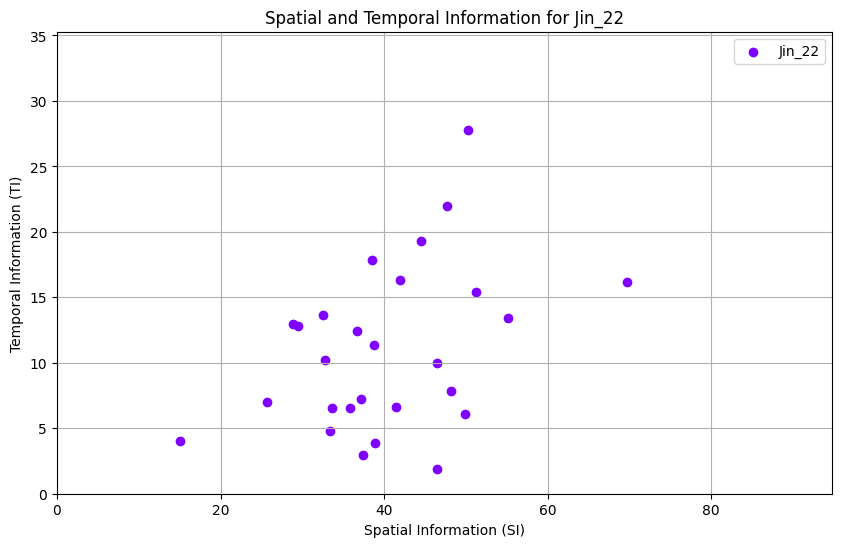

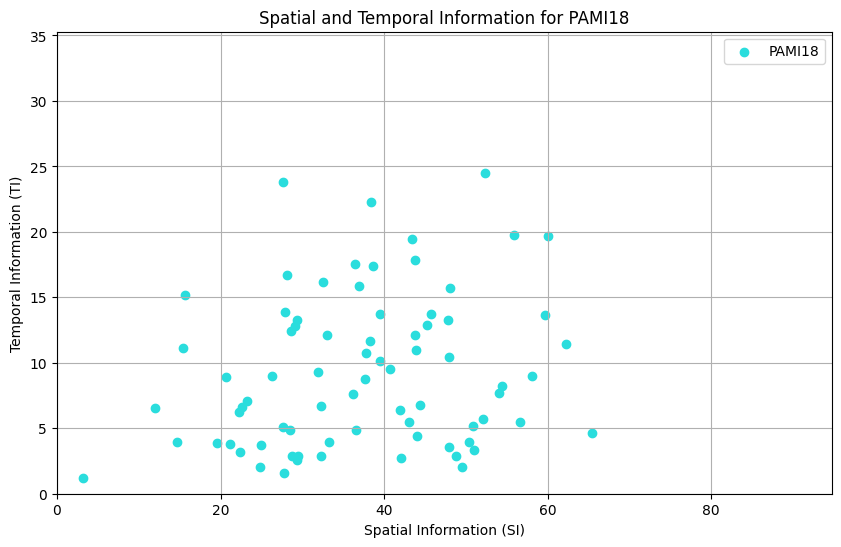

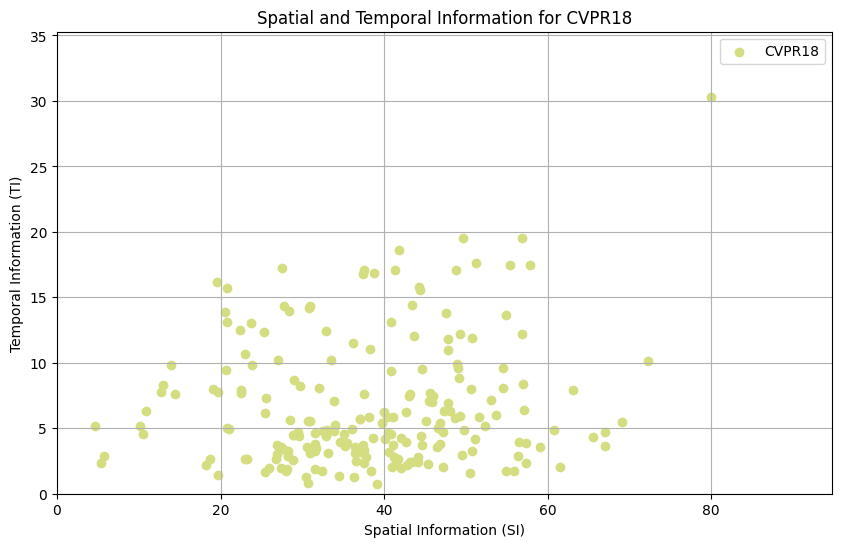

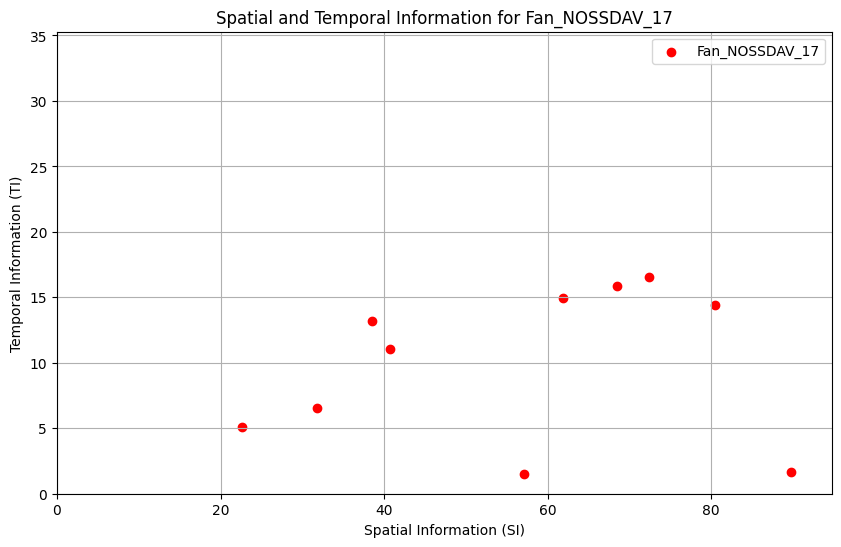

In [13]:
plot_all_SITI(datasets_folder,datasets)

In [14]:
def fetch_c_entropies(datasets_folder, dataset):
    dataset_folder = os.path.join(datasets_folder, dataset)
    video_img_folder = os.path.join(dataset_folder, '5fps_Video_Images')
    data_path = os.path.join(dataset_folder, 'video_data')
    videos = os.listdir(video_img_folder)
    entropies = {}
    
    for video in videos:
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        
        if os.path.exists(entropy_path):
            entropy = np.load(entropy_path)
            entropies[video] = entropy
            
    return entropies

In [15]:
def plot_mean_entropy_vs_SITI(datasets_folder, dataset):
    dataset_folder = os.path.join(datasets_folder, dataset)

    data_path = os.path.join(dataset_folder, 'video_data')
    
    videos = os.listdir(data_path)
    mean_SIs = []
    mean_TIs = []
    mean_entropies = []
    
    for video in videos:
        # Load SI and TI values
        array_folder = os.path.join(data_path, video)
        SI_path = os.path.join(array_folder, 'video_SI.npy')
        TI_path = os.path.join(array_folder, 'video_TI.npy')
        
        if os.path.exists(SI_path) and os.path.exists(TI_path):
            SI = np.load(SI_path)
            TI = np.load(TI_path)
            mean_SIs.append(np.mean(SI))
            mean_TIs.append(np.mean(TI))
        
        # Load content entropy values
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        
        if os.path.exists(entropy_path):
            entropy = np.load(entropy_path)
            mean_entropies.append(np.mean(entropy))
    
    # Determine vmin and vmax for the colormap to handle outliers
    vmin = np.percentile(mean_entropies, 5)
    vmax = np.percentile(mean_entropies, 95)
    
    # Plot mean SI vs mean TI with content entropy as colormap
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(mean_SIs, mean_TIs, c=mean_entropies, cmap='coolwarm', marker='o', vmin=vmin, vmax=vmax)
    
    plt.title(f'Mean TI vs Mean SI with Content Entropy for {dataset}')
    plt.xlabel('Mean Spatial Information (SI)')
    plt.ylabel('Mean Temporal Information (TI)')
    colorbar = plt.colorbar(scatter, label='Mean Content Entropy')
    plt.grid(True)
    plt.tight_layout()
    plots_folder = os.path.join('Plots', 'SITI_entropy')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset}_SITI_with_entropy_plot.png')
    plt.savefig(plot_path)
    plt.show()

In [33]:
def plot_mean_entropy_vs_SITI_alldatasets(datasets_folder, datasets,fontsize=12):
    global_min_SI, global_max_SI = float('inf'), float('-inf')
    global_min_TI, global_max_TI = float('inf'), float('-inf')
    video_SIs={}
    video_TIs={}
    video_CEs={}

    for idx, dataset_name in enumerate(datasets):
        dataset_folder = os.path.join(datasets_folder, dataset_name)
        video_img_folder = os.path.join(dataset_folder, 'video_data')
        videos = os.listdir(video_img_folder)
        video_SIs[dataset_name] = []
        video_TIs[dataset_name] = []
        video_CEs[dataset_name]=[]
        for video in videos:
            array_folder = os.path.join(video_img_folder, video)
            SI = np.load(os.path.join(array_folder, f'{video}_SI.npy'))
            TI = np.load(os.path.join(array_folder, f'{video}_TI.npy'))
            CE=np.load(os.path.join(array_folder,f'{video}_content_entropy.npy'))
            mean_SI, mean_TI, mean_CE=np.mean(SI),np.mean(TI),np.mean(CE)
            global_min_SI = min(global_min_SI, mean_SI)
            global_max_SI = max(global_max_SI, mean_SI)
            global_min_TI = min(global_min_TI, mean_TI)
            global_max_TI = max(global_max_TI, mean_TI)
            # Aggregating based on ITU-T P.910 (10/2023)
            
            video_SIs[dataset_name].append(mean_SI)
            video_TIs[dataset_name].append(mean_TI)
            video_CEs[dataset_name].append(mean_CE)
    
    for idx, dataset_name in enumerate(datasets):
        plt.figure(figsize=(10, 6))
        vmin = np.percentile(video_CEs[dataset_name], 5)
        vmax = np.percentile(video_CEs[dataset_name], 95)
        #scatter = plt.scatter(mean_SIs, mean_TIs, c=mean_entropies, cmap='coolwarm', marker='o', vmin=vmin, vmax=vmax)
        scatter=plt.scatter(video_SIs[dataset_name], video_TIs[dataset_name], 
                            c=video_CEs[dataset_name],cmap='coolwarm',
                            marker='o', vmin=vmin, vmax=vmax)
        #plt.title(f'Mean TI vs Mean SI with Content Entropy for {dataset_name}')
        plt.xlabel('Mean Spatial Information (SI)',fontsize=fontsize)
        plt.ylabel('Mean Temporal Information (TI)',fontsize=fontsize)
        colorbar = plt.colorbar(scatter)   
        colorbar.set_label(label='Mean Content Entropy', size=fontsize-3)     
        #plt.legend()
        plt.xlim(0, global_max_SI+5)
        plt.ylim(0, global_max_TI+5)
        #plt.grid(True)
        plt.tight_layout()
        plots_folder = os.path.join('Plots', 'SITI_entropy')
        os.makedirs(plots_folder, exist_ok=True)
        plot_path = os.path.join(plots_folder, f'{dataset_name}_SITI_with_entropy_plot.png')
        plt.savefig(plot_path)
        plt.show()    

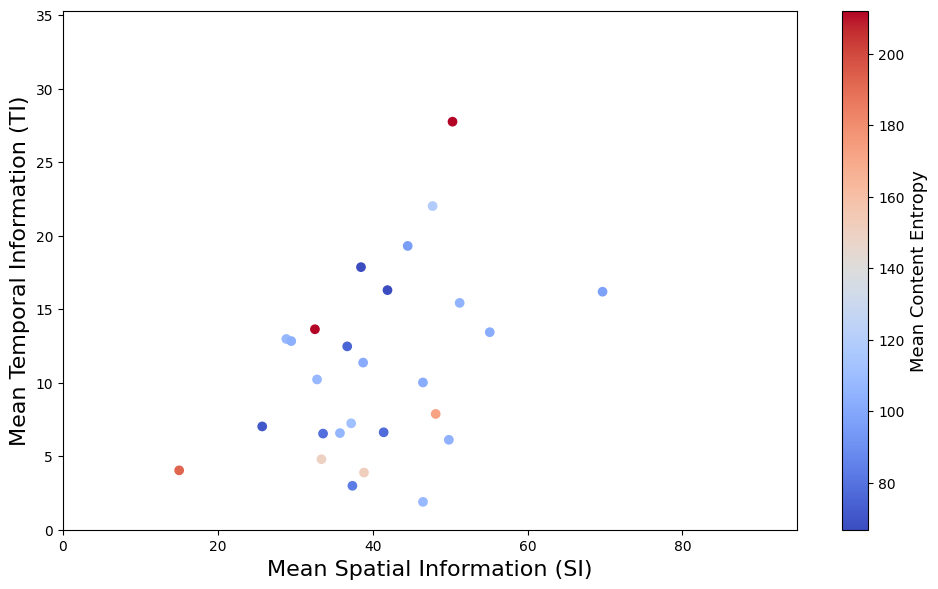

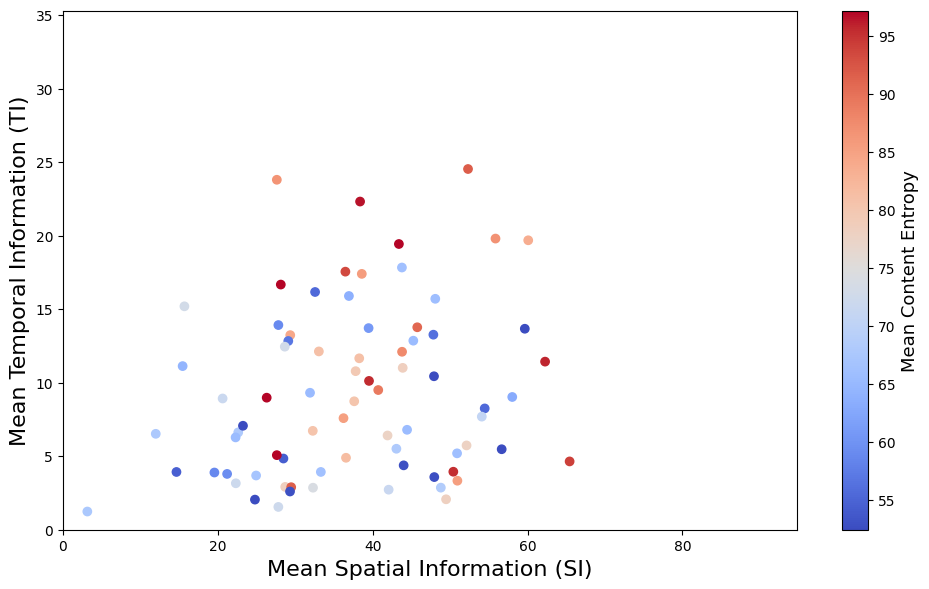

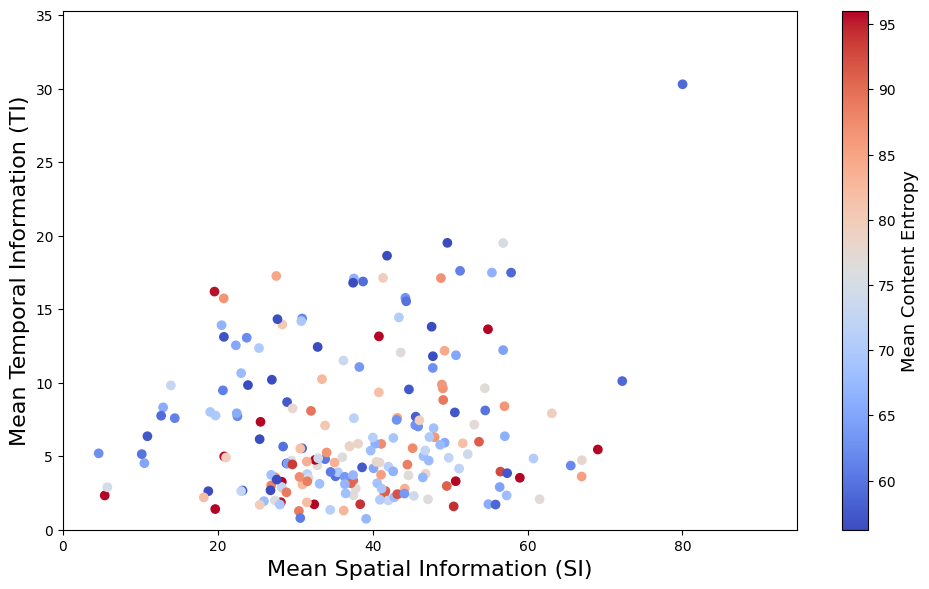

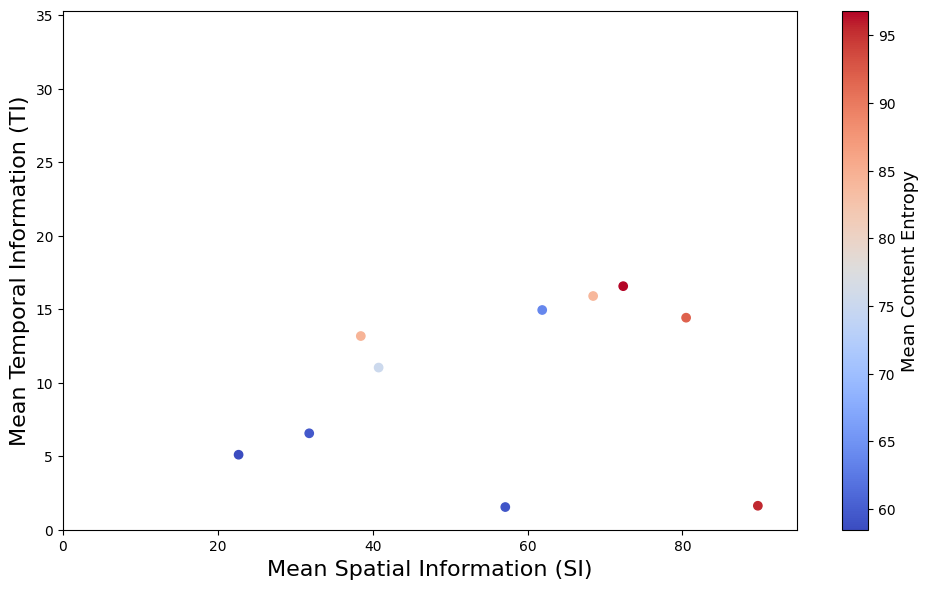

In [34]:
plot_mean_entropy_vs_SITI_alldatasets(datasets_folder,datasets,fontsize=16)